# Προγραμματιστική άσκηση:
### Ταξινόμηση καρδιοτοκογραφικών σημάτων με βάση την μεταβλητότητα του καρδιακού ρυθμού

## Section 1
* ##### Load and store data to dataframe

In [1]:
import pandas as pd
import numpy as np  
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import glob
import re
import pyhrv.time_domain as td
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
* Convert .dat files to .csv
* Create ann_db file for easier processing of additional annotations

@ Decomment the below command in order to execute in your own 

"""
# %run create_csv_database.py

'\n* Convert .dat files to .csv\n* Create ann_db file for easier processing of additional annotations\n\n@ Decomment the below command in order to execute in your own \n\n'

In [3]:
"""
* Convert .dat files to .csv
* Create ann_db dataframe for easier processing of additional annotations
"""
ann_db = pd.read_csv("database/ann_db.csv")
ann_db.rename(columns={'Unnamed: 0':'Labels'}, inplace=True)
ann_db = ann_db.set_index('Labels')
ann_db.head()

"""
* Initialize dataframe which we will apply 
    - methods for Heart Rate Variability (HRV) computation 
    based on Fatal Heart Rate signals (FHR)
    - correlation and other types of analysis
"""

def init_dataframe(path = "database/signals"):
    files = glob.glob(path + "/*.csv")
    data_frame = pd.DataFrame()

    for filename in files:
        name = re.sub("[^0-9]", "", filename)
        df = pd.read_csv(filename, index_col=None)
        data_frame = data_frame.append(
            {
                'tag': name,
                'Fhr': list(df['FHR']), 
                'pH': ann_db[name]['pH'],
                'Apgar1': ann_db[name]['Apgar1'],
                'Apgar5': ann_db[name]['Apgar5'],
                'Weight(g)': ann_db[name]['Weight(g)'],
                'labels': ann_db[name]
            },
            ignore_index=True
        )
    return data_frame

df = init_dataframe()
df.head()

,tag,Fhr,pH,Apgar1,Apgar5,Weight(g),labels
0,1001,"[150.5, 150.5, 151.0, 151.25, 151.25, 150.25, ...",7.14,6.0,8.0,2660.0,Labels pH 7.14 BDecf ...
1,1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",7.00,8.0,8.0,2900.0,Labels pH 7.00 BDecf ...
2,1003,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",7.20,7.0,9.0,3770.0,Labels pH 7.20 BDecf ...
3,1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",7.30,8.0,9.0,3370.0,Labels pH 7.30 BDecf ...
4,1005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.30,9.0,10.0,3550.0,Labels pH 7.30 BDecf ...


### Data Description:
##### A short (non medically exhaustive) description of the feature meaning

**analysis of umbilical artery blood sample**
- **pH** : Is the ph of the blood of the baby (n.v. 7.35-7.45). A slight increase causes blood alkalosis while a slight decrease causes acidosis. Both conditions are extremely life threatening. This value is inverse proportional to **pCO2**.
- **BDecf** : Base excess of extracellular fluid is a quantity that reflects only the non-respiratory (metabolic) component of acid-base disturbances. (Reference : [Here](https://acutecaretesting.org/en/articles/all-about-base-excess--to-be-or-not-to-be))
- **pCO2** : is the relative pressure of CO2 in the blood (n.v. 4.5-6.0Kpa). In Respiratory Acidosis, **pH** and **pCO2** are inverse proportional while in Metabolic Acidosis they are directly proportional.
- **BE** : is the excess or deficit (if negative) of bases in the blood (e.g. HCO3). The normal range is between -2 and +2 mEq/L or mmol/L. A value above the range is indicative of Metabolic Alkalosis while below the range is indicative of Metabolic Acidosis.

- **Apgar1** : It's the Apgar score at 1min from birth. It indicates the overall health status of the baby at birth. It can have values between 0 and 10 where a score above 7 is considered good. (Reference and table : [Here](https://www.birthinjurysafety.org/birth-injuries/apgar-scoring-system.html))
- **Apgar5** : It's the Apgar score at 5min from birth. See **Apgar1**.
- **Gest. weeks** : It's the number of weeks of gestation where 39-40 weeks represent a normal term delivery.
- **Weight(g)** : Is the weigth of the baby in grams at birth. This is various but in general the normal range would be between 2500g and 4500g.
- **Sex** : This is a boolean for 1 and 2 where is not clear which is male/female but shouldn't matter.
- **Age** : The Age in years of the mom.
- **Gravidity** : Is the number of times the woman has been pregnant in her life.
- **Parity** : Is the number of times the woman has been pregnant for more than 24 weeks (in a single pregnancy).
- **Diabetes** : Boolean value for Diabetes of 0 (False) and 1 (True).
- **Hypertension** : Boolean value for Hypertension of 0 (False) and 1 (True).
- **Preeclampsia** : Boolean value for Preeclampsia of 0 (False) and 1 (True). where Preeclampsia indicate a disorder of pregnancy that could lead to complications.
- **Liq.** : It referes to Liquor which in this case is the Amniotic Fluid. I'm not sure why is a boolean in the data.
- **Pyrexia** : Is a boolean value that indicate the presence of pyrexia (high temperature) in the mom or not.
- **Meconium** : Is a boolean value that indicate the presence or not of Meconium which is the earliest stool of the baby that could happen before partum.
- **Presentation** : This indicate the presentation of the baby during delivery which can be head first, legs first etc. The problem here is that this value is a number which most probably refers to an internal classification or a scale I don't know how to interpret. **See also Deliv. type**
- **Induced** : Is a boolean value that indicate if the delivery has been medically induced.
- **I.stage** : It should indicate the time in between contractions in the stage of the delivery but this is only my observational opinon based on the data.
- **NoProgress** : Is a boolean value that indicate if there has been an abort of the pregnancy or not.
- **CK/KP** : It should refer to the level of Creatine Kinase?
- **II.stage** : see **I.stage**.
- **Deliv. type** : (1: vaginal; 2: operative vaginal; 3: CS)
- **dbID** : is just an ID of the record
- **Rec. type** : No idea
- **Pos. II.st.** : No idea

# Section 2
### Description
##### Functions for
- **noisy records removal**
- **large zero segments removal**
- **records that do not agree with restrictions** 
(such as casarean records, underage mothers and so on) **removal**
- **noise retrieval** (where noisy values predefined to 0) 
##### are defined

Preprocessing parameters are defined:
* SEGMENT_SIZE refers to the minimum number of consecutive zero measurments that must be thrown as segment of the signal. Those segments are not worth for further analysis.
*  NOISY_THRESH refers to the maximum percentage of zero measurments that mast have a signal to be considered under analysis
* NOISE_RETRV_THRESH refers to high and low cut limiter (value %) of signal measurments.
* N_PREV_VALS is the number of values that must take into account to compute a median. If a measurment value in a signal is greater or less than itself multiplied by NOISE_RETRV_THRESH, median that refered above replaces that signal measurment. We do more simply signal smoothing.


In [4]:
SEGMENT_SIZE = 25 
NOISY_THRESH = 0.20
NOISE_RETRV_THRESH = 0.25 
N_PREV_VALS = 10 

We drope records when:
* The birth was performed by caesarean section
* Mother was underaged
* Mother diseases such as Hypertension, Preeclampsia, etc.
* Where gestation weeks are under the normal

In [5]:
def drop_restictions(df, name):
    records_to_drop = list()
    cc = ca = cd = cw = 0
    
    for i in range(df.shape[0]):
        if (df.iloc[i]['labels']['Deliv. type'] != 1.0):
            records_to_drop.append(i); cc+=1

        if (df.iloc[i]['labels']['Age'] < 18):
            records_to_drop.append(i); ca+=1

        if (df.iloc[i]['labels']['Hypertension'] == 1 or
            df.iloc[i]['labels']['Preeclampsia'] == 1 or 
            df.iloc[i]['labels']['Diabetes'] == 1):
            records_to_drop.append(i); cd+=1

        if (df.iloc[i]['labels']['Gest. weeks'] < 37.5):
            records_to_drop.append(i); cw+=1
    
    print('--',name,'--')
    print(cw,' underweeked records dropped')
    print(cd,' diseased records dropped')
    print(ca,' underage records dropped')
    print(cc,' casarean records dropped')
    
    print(len(records_to_drop), 'total records dropped')
    return df.drop(records_to_drop).reset_index().drop('index', axis=1)

In [6]:
def drop_noisy_records(df, thresh=0.2):
    noisy_records = list()
    
    for i in range(df.shape[0]):
        record = df.iloc[i]
        perc_zeros = record['Fhr'].count(0) / len(record['Fhr'])
        if( perc_zeros > thresh ):
            noisy_records.append(i)    
    return  df.drop(noisy_records).reset_index().drop('index', axis=1)

In [7]:
def drop_zero_segments(df_input, segment_size = 20):
    df = df_input.copy()
    
    for row_i , fhr in df_input['Fhr'].iteritems():
        fhr_list = list(fhr) # get fhr of record row_i as list
        fhr_list_out = list() # set an empty list
        count = 0
        for j, value in enumerate(fhr_list):     
            if(value == 0):
                count += 1                
            else:
                if(count >= segment_size):
                    fhr_list_out = fhr_list_out[:-count]
                count = 0    
            fhr_list_out.append(value)
        df.at[row_i, 'Fhr'] = fhr_list_out
        
    return df

In [8]:
from statistics import median 

def get_median(lst, index, n_prev_vals):
    medians = list()
    for i in range(index, 0, -1):
        if(lst[i] != 0):
            medians.append(lst[i])
        if(len(medians)==n_prev_vals):
            return median(medians)

    return median(lst)
            
def noise_retrieval(df_input, thres = 0.25, n_prev_vals=3):
    df = df_input.copy()
    for row_i , fhr in df['Fhr'].iteritems():
        fhr_new = list()
        for i in range(len(fhr)):
            prev_values_med = get_median(fhr, i, n_prev_vals)
            if(fhr[i] > prev_values_med + prev_values_med * thres or 
            fhr[i] < prev_values_med - prev_values_med * thres ):
                fhr_new.append(prev_values_med)
            else: 
                fhr_new.append(fhr[i])
        df.at[row_i,'Fhr'] = fhr_new
        
    return df 

In [9]:
df_r = drop_restictions(df,'df')
df_r_n = drop_noisy_records(df_r,thresh=NOISY_THRESH)
df_r_n_zs = drop_zero_segments(df_r_n, segment_size=SEGMENT_SIZE)
df_r_n_zs = df_r_n_zs.set_index('tag')
df_r_n_zs_sm = noise_retrieval(df_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)

-- df --
18  underweeked records dropped
86  diseased records dropped
0  underage records dropped
46  casarean records dropped
150 total records dropped


In [10]:
df_r_n_zs_sm

,Fhr,pH,Apgar1,Apgar5,Weight(g),labels
tag,,,,,,
1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",7.00,8.0,8.0,2900.0,Labels pH 7.00 BDecf ...
1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",7.30,8.0,9.0,3370.0,Labels pH 7.30 BDecf ...
1008,"[124.0, 124.0, 124.0, 124.0, 124.0, 124.0, 124...",7.36,8.0,9.0,3360.0,Labels pH 7.36 BDecf ...
1011,"[149.5, 149.75, 149.75, 150.0, 150.0, 150.25, ...",7.37,8.0,9.0,2400.0,Labels pH 7.37 BDecf ...
1014,"[145.0, 145.0, 146.0, 145.5, 145.5, 146.5, 146...",7.14,9.0,9.0,3610.0,Labels pH 7.14 BDecf ...
...,...,...,...,...,...,...
1499,"[140.25, 136.25, 136.25, 139.5, 140.25, 140.25...",7.24,9.0,10.0,2200.0,Labels pH 7.24 BDecf ...
1502,"[114.5, 114.5, 114.5, 114.5, 114.5, 114.5, 114...",7.26,9.0,10.0,3520.0,Labels pH 7.26 BDecf ...
1503,"[127.75, 127.75, 127.75, 131.5, 131.5, 132.75,...",7.31,9.0,10.0,3700.0,Labels pH 7.31 BDecf ...


## Section 3a
### Experiments (all cardiotocographic signals included)

* ##### Methods applied for Heart Rate Variability calculation
- **sdnn**
- **rmssd**
- **sdann** 
- **nn20**

* ##### Types for correlation calculation
- **Pearson**
- **Spearman**
- **Kendall rank** 

In [11]:
def compute_hrv(df_input):
    df = df_input.copy()
    
    sdnn = list(); rmssd = list(); sdann = list(); nn20 = list()
    for row_i, fhr in tqdm(df['Fhr'].iteritems(), total=df.shape[0]):
        sdnn.append(td.sdnn(np.array(df.loc[row_i]['Fhr']))[0])
        rmssd.append(td.rmssd(np.array(df.loc[row_i]['Fhr']))[0])
        sdann.append(td.sdann(np.array(df.loc[row_i]['Fhr']))[0])
        nn20.append(td.nn20(np.array(df.loc[row_i]['Fhr']))[0])

    df['sdnn'] = sdnn
    df['rmssd'] = rmssd
    df['sdann'] = sdann
    df['nn20'] = nn20
    
    return df 

df_fin = compute_hrv(df_r_n_zs_sm)
df_fin.head()

  0%|          | 0/234 [00:00<?, ?it/s]

,Fhr,pH,Apgar1,Apgar5,Weight(g),labels,sdnn,rmssd,sdann,nn20
tag,,,,,,,,,,
1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",7.00,8.0,8.0,2900.0,Labels pH 7.00 BDecf ...,24.151512,2.788846,17.799355,67
1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",7.30,8.0,9.0,3370.0,Labels pH 7.30 BDecf ...,22.216154,1.894141,20.632604,23
1008,"[124.0, 124.0, 124.0, 124.0, 124.0, 124.0, 124...",7.36,8.0,9.0,3360.0,Labels pH 7.36 BDecf ...,14.888796,2.232269,8.652947,47
1011,"[149.5, 149.75, 149.75, 150.0, 150.0, 150.25, ...",7.37,8.0,9.0,2400.0,Labels pH 7.37 BDecf ...,22.151290,2.805503,18.777693,40
1014,"[145.0, 145.0, 146.0, 145.5, 145.5, 146.5, 146...",7.14,9.0,9.0,3610.0,Labels pH 7.14 BDecf ...,23.719984,2.866754,15.362750,93


In [12]:
df_fin.to_csv('s3a.csv', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df_fin.to_excel('s3a.xlsx', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])

In [33]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def get_correlation(df, clmn1='sdnn', clmn2='pH'):
    results = {'pearsonr':list(), 'spearmanr':list(), 'kendalltau':list()}
    results['pearsonr'].append( 
        pearsonr(
            df[clmn1] ,
            df[clmn2]
        )
    )
    results['spearmanr'].append( 
        spearmanr(
            df[clmn1] ,
            df[clmn2]
        )
    )
    results['kendalltau'].append( 
        kendalltau(
            df[clmn1] ,
            df[clmn2]
        )
    )
    return results

print('--sdnn--')
print('PearsonResult: ',get_correlation(df_fin, clmn1='sdnn')['pearsonr'])
print(get_correlation(df_fin, clmn1='sdnn')['spearmanr'])
print(get_correlation(df_fin, clmn1='sdnn')['kendalltau'])
print('--rmssd--');print()
print('PearsonResult: ',get_correlation(df_fin, clmn1='rmssd')['pearsonr'])
print(get_correlation(df_fin, clmn1='rmssd')['spearmanr'])
print(get_correlation(df_fin, clmn1='rmssd')['kendalltau'])
print('--sdann--');print()
print('PearsonResult: ',get_correlation(df_fin, clmn1='sdann')['pearsonr'])
print(get_correlation(df_fin, clmn1='sdann')['spearmanr'])
print(get_correlation(df_fin, clmn1='sdann')['kendalltau'])
print('--nn20--');print()
print('PearsonResult: ',get_correlation(df_fin, clmn1='nn20')['pearsonr'])
print(get_correlation(df_fin, clmn1='nn20')['spearmanr'])
print(get_correlation(df_fin, clmn1='nn20')['kendalltau'])

--sdnn--
PearsonResult:  [(-0.39567672298754225, 3.4212584110687123e-10)]
[SpearmanrResult(correlation=-0.3630261830842476, pvalue=1.0663693073153829e-08)]
[KendalltauResult(correlation=-0.2544193541309007, pvalue=1.1415314627407688e-08)]
--rmssd--

PearsonResult:  [(-0.22905412563779895, 0.00041216899652788005)]
[SpearmanrResult(correlation=-0.21662109804196714, pvalue=0.0008511090930319263)]
[KendalltauResult(correlation=-0.1469423631665653, pvalue=0.0009777676925193496)]
--sdann--

PearsonResult:  [(-0.2706068641927098, 2.7182358397645852e-05)]
[SpearmanrResult(correlation=-0.21596877588695956, pvalue=0.0008831515300084195)]
[KendalltauResult(correlation=-0.14738956285157645, pvalue=0.0009434114119386287)]
--nn20--

PearsonResult:  [(-0.2453256683229023, 0.000150188912390355)]
[SpearmanrResult(correlation=-0.26355613281804574, pvalue=4.4562264631637314e-05)]
[KendalltauResult(correlation=-0.18263904182695442, pvalue=4.551262291803253e-05)]


### Experiments conclusions (all cardiotocographic signals included)

* There is a statistically significant negative correlation between HRV (sdnn method significally reveals this correlation) and pH. Furthermore, this can be seen also in the results that emerge by visualizing the relationship in 2-d space. It turns out that as the HRV increases, pH value decreases relatively. A conclusion of course that has been shown in previous research.

<AxesSubplot:title={'center':'nn20: corr=-0.245 p=0.0'}>

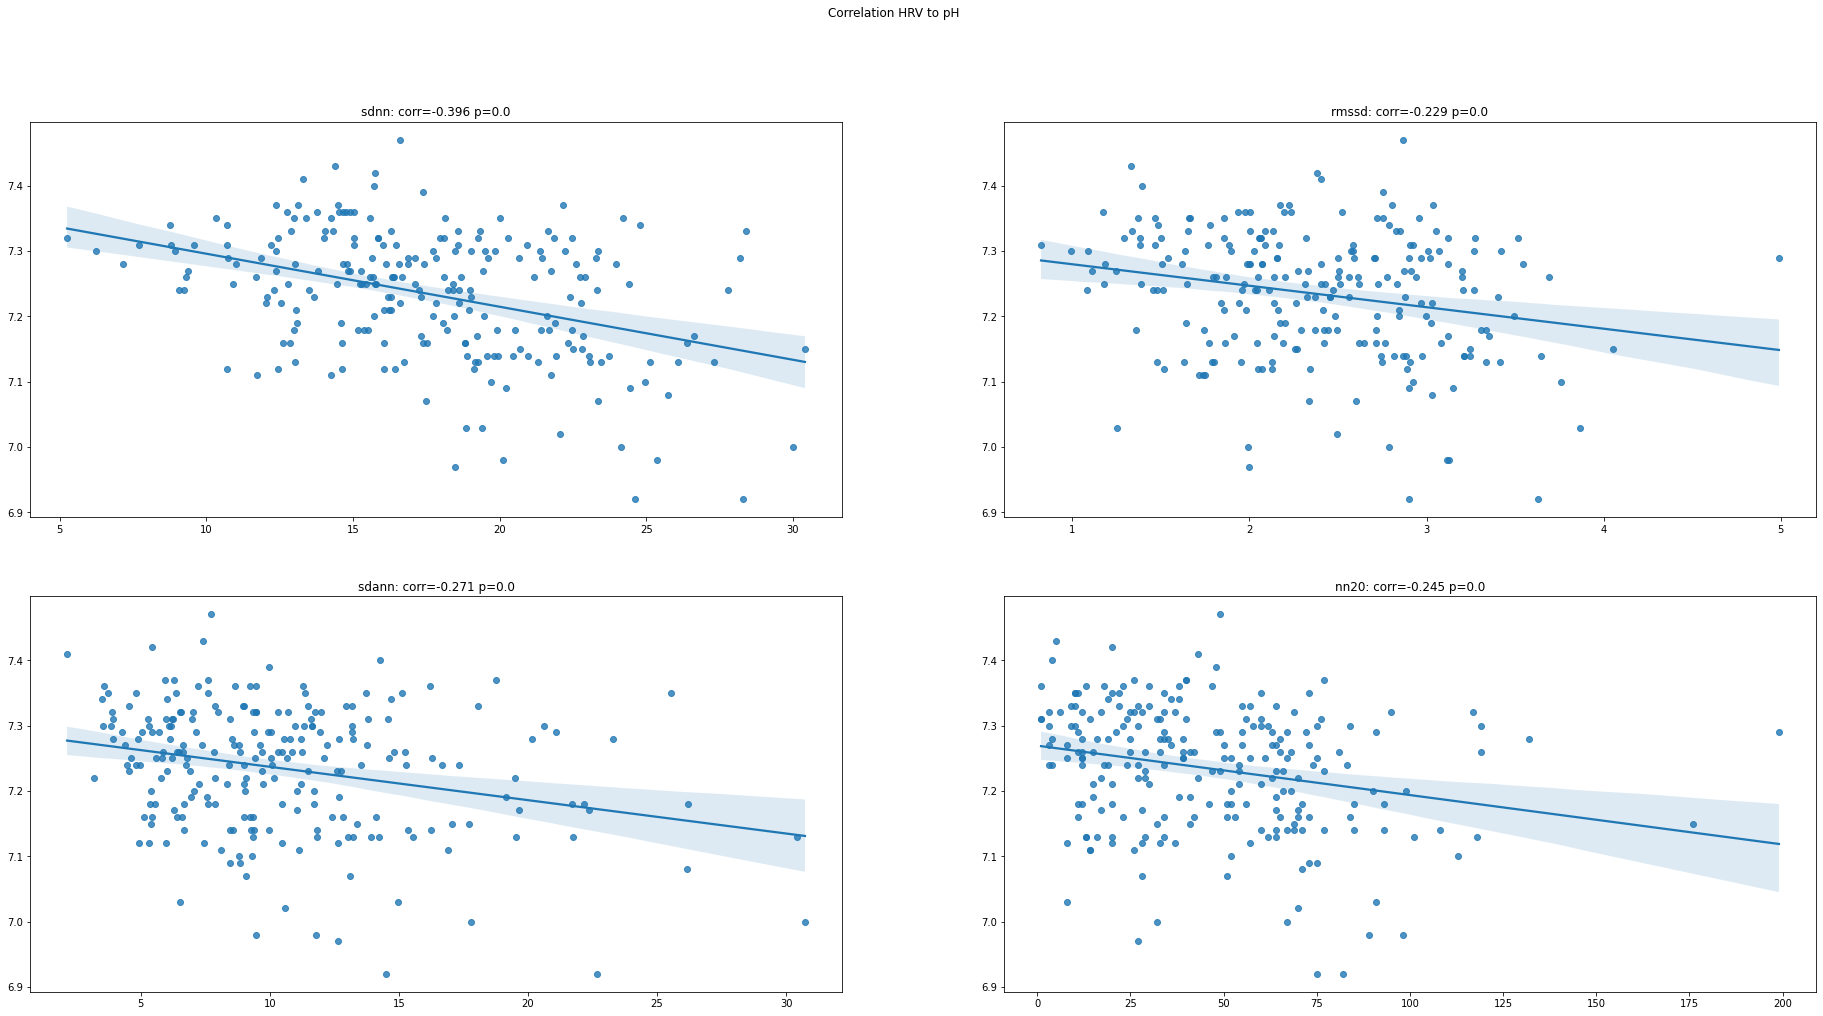

In [14]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(32, 16))
fig.suptitle('Correlation HRV to pH')
axes[0][0].set_title('sdnn: corr=' + str(round(get_correlation(df_fin, clmn1='sdnn')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df_fin, clmn1='sdnn')['pearsonr'][0][1],3))); 
axes[0][1].set_title('rmssd: corr=' + str(round(get_correlation(df_fin, clmn1='rmssd')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df_fin, clmn1='rmssd')['pearsonr'][0][1],3))); 
axes[1][0].set_title('sdann: corr=' + str(round(get_correlation(df_fin, clmn1='sdann')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df_fin, clmn1='sdann')['pearsonr'][0][1],3))); 
axes[1][1].set_title('nn20: corr=' + str(round(get_correlation(df_fin, clmn1='nn20')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df_fin, clmn1='nn20')['pearsonr'][0][1],3))); 

sns.regplot(ax=axes[0][0], x=[hrv_val for _, hrv_val in df_fin['sdnn'].iteritems()], y=[hrv_val for _, hrv_val in df_fin['pH'].iteritems()])
sns.regplot(ax=axes[0][1], x=[hrv_val for _, hrv_val in df_fin['rmssd'].iteritems()], y=[hrv_val for _, hrv_val in df_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][0], x=[hrv_val for _, hrv_val in df_fin['sdann'].iteritems()], y=[hrv_val for _, hrv_val in df_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][1], x=[hrv_val for _, hrv_val in df_fin['nn20'].iteritems()], y=[hrv_val for _, hrv_val in df_fin['pH'].iteritems()])


## Section 3b
### Experiments (healthy births separated from the unhealthy due to Apgar values)

* ##### Methods applied for Heart Rate Variability
- **sdnn**
- **rmssd**
- **sdann** 
- **nn20**

* ##### Types for correlation calculation
- **Pearson**
- **Spearman**
- **Kendall rank** 

As refered on Data Description the Apgar score indicates the overall health status of the baby at 1min from birth. It can have values between 0 and 10 where a score above 7 is considered good.

The 2 main reasons that it was decided to separate the signals in healthy baby status and unhealthy are explained below:

* We want to analyze and confirm whether the correlation of the complete set of signals remains the same strong and important in the partially separated sets of signals. If it is not confirmed there
* To study the change of correlation, when the measurement Apgar is done after 1 (Apgar1) or 5 (Apgar5) minutes. 

<b>For the last reason we divided the signals into 4 sets. HEALTHY AND UNHEALTHY based on measurment Apgar1 and measurement Apgar5</b>

Note: We follow the same process as we did in <i>Section 3b</i>.

In [15]:
'''
* init in dataframe a separate column that indicates the healthy state according to Apgar 1
* healthy_thresh >= 7
'''
healthy_thresh = 7
for i, signal in df.iterrows():
    df.at[i,'Healthy Birth (1)'] = 1 if(df.iloc[i]['Apgar1'] >= healthy_thresh) else 0
    df.at[i,'Fhr'] = df.iloc[i]['Fhr'][:14400]


# keep in a dataframe named 'df1h' only those whose Apgar1 are greater than 7 (healthy state)
df1h = df[df['Healthy Birth (1)'] == 1].reset_index().drop('index', axis=1)
# keep in a dataframe named 'df1u' only those whose Apgar1 are less than 7 (unhealthy state)
df1u = df[df['Healthy Birth (1)'] == 0].reset_index().drop('index', axis=1)


'''
* init in dataframe a separate column that indicates the healthy state according to Apgar 1
* healthy_thresh >= 7
'''
healthy_thresh = 7
for i, signal in df.iterrows():
    df.at[i,'Healthy Birth (2)'] = 1 if(df.iloc[i]['Apgar5'] >= healthy_thresh) else 0
    df.at[i,'Fhr'] = df.iloc[i]['Fhr'][:14400]

# keep in a dataframe named 'df1h' only those whose Apgar5 are greater than 7 (healthy state)
df5h = df[df['Healthy Birth (2)'] == 1].reset_index().drop(['index','Healthy Birth (2)'], axis=1)
# keep in a dataframe named 'df1u' only those whose Apgar5 are less than 7 (unhealthy state)
df5u = df[df['Healthy Birth (2)'] == 0].reset_index().drop(['index','Healthy Birth (2)'], axis=1)

df1h.head()

,tag,Fhr,pH,Apgar1,Apgar5,Weight(g),labels,Healthy Birth (1)
0,1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",7.00,8.0,8.0,2900.0,Labels pH 7.00 BDecf ...,1.0
1,1003,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",7.20,7.0,9.0,3770.0,Labels pH 7.20 BDecf ...,1.0
2,1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",7.30,8.0,9.0,3370.0,Labels pH 7.30 BDecf ...,1.0
3,1005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.30,9.0,10.0,3550.0,Labels pH 7.30 BDecf ...,1.0
4,1006,"[143.5, 142.75, 142.75, 142.75, 142.75, 141.5,...",7.23,8.0,9.0,3500.0,Labels pH 7.23 BDecf ...,1.0


In [16]:
df1h_r = drop_restictions(df1h,'df1h')
df1u_r = drop_restictions(df1u,'df1u')
df5h_r = drop_restictions(df5h,'df5h')
df5u_r = drop_restictions(df5u,'df5u')

df1h_r_n = drop_noisy_records(df1h_r,thresh=NOISY_THRESH)
df1u_r_n = drop_noisy_records(df1u_r,thresh=NOISY_THRESH)
df5h_r_n = drop_noisy_records(df5h_r,thresh=NOISY_THRESH)
df5u_r_n = drop_noisy_records(df5u_r,thresh=NOISY_THRESH)

df1h_r_n_zs = drop_zero_segments(df1h_r_n, segment_size=SEGMENT_SIZE)
df1u_r_n_zs = drop_zero_segments(df1u_r_n, segment_size=SEGMENT_SIZE)
df5h_r_n_zs = drop_zero_segments(df5h_r_n, segment_size=SEGMENT_SIZE)
df5u_r_n_zs = drop_zero_segments(df5u_r_n, segment_size=SEGMENT_SIZE)

df1h_r_n_zs = df1h_r_n_zs.set_index('tag')
df1u_r_n_zs = df1u_r_n_zs.set_index('tag')
df5h_r_n_zs = df5h_r_n_zs.set_index('tag')
df5u_r_n_zs = df5u_r_n_zs.set_index('tag')

df1h_r_n_zs_sm = noise_retrieval(df1h_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df1u_r_n_zs_sm = noise_retrieval(df1u_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df5h_r_n_zs_sm = noise_retrieval(df5h_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df5u_r_n_zs_sm = noise_retrieval(df5u_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)

df1h_fin = compute_hrv(df1h_r_n_zs_sm)
df1u_fin = compute_hrv(df1u_r_n_zs_sm)
df5h_fin = compute_hrv(df5h_r_n_zs_sm)
df5u_fin = compute_hrv(df5u_r_n_zs_sm)

-- df1h --
13  underweeked records dropped
74  diseased records dropped
0  underage records dropped
35  casarean records dropped
122 total records dropped
-- df1u --
5  underweeked records dropped
12  diseased records dropped
0  underage records dropped
11  casarean records dropped
28 total records dropped
-- df5h --
18  underweeked records dropped
82  diseased records dropped
0  underage records dropped
43  casarean records dropped
143 total records dropped
-- df5u --
0  underweeked records dropped
4  diseased records dropped
0  underage records dropped
3  casarean records dropped
7 total records dropped


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
df1h_fin.to_csv('apgar1healthy.csv', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df1u_fin.to_csv('apgar1unhealthy.csv', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df5h_fin.to_csv('apgar5healthy.csv', columns=['Healthy Birth (1)', 'pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df5u_fin.to_csv('apgar5unhealthy.csv', columns=['Healthy Birth (1)', 'pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])

df1h_fin.to_excel('apgar1healthy.xlsx', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df1u_fin.to_excel('apgar1unhealthy.xlsx', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df5h_fin.to_excel('apgar5healthy.xlsx', columns=['Healthy Birth (1)', 'pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df5u_fin.to_excel('apgar5unhealthy.xlsx', columns=['Healthy Birth (1)', 'pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])

<AxesSubplot:title={'center':'nn20: corr=-0.233 p=0.0'}>

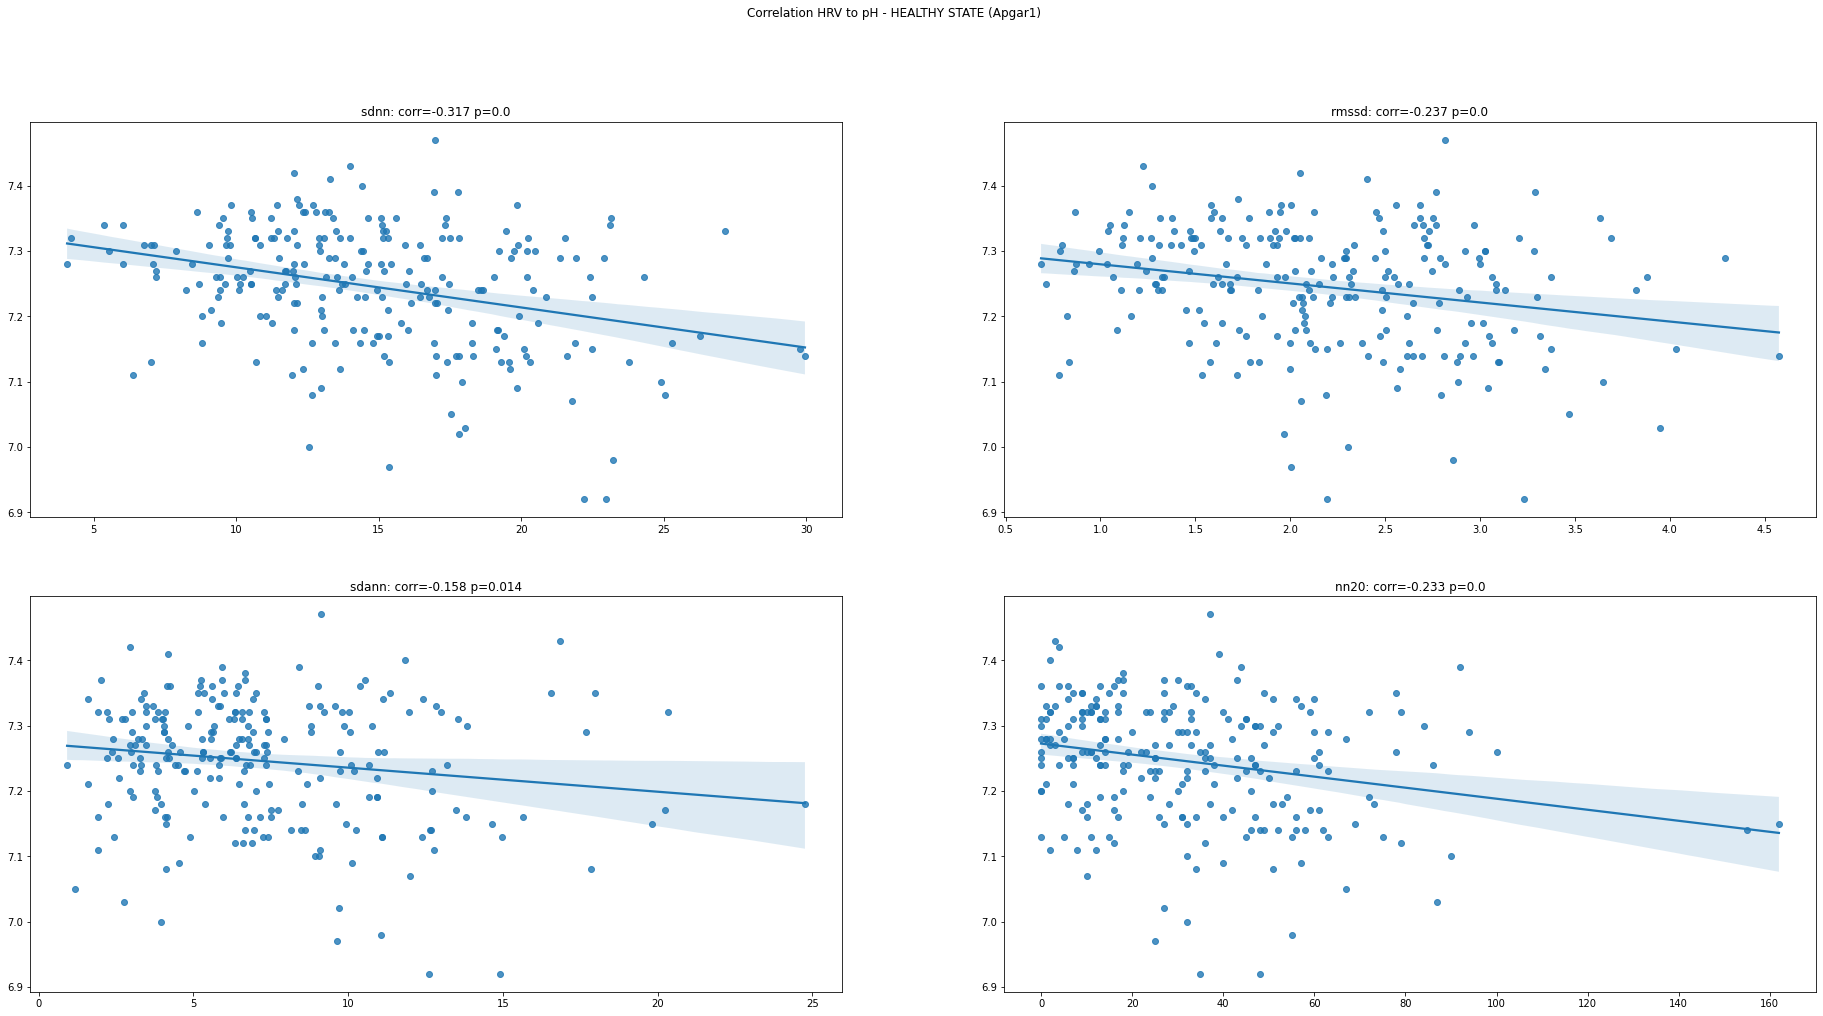

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(32, 16))

fig.suptitle('Correlation HRV to pH - HEALTHY STATE (Apgar1)')
axes[0][0].set_title('sdnn: corr=' + str(round(get_correlation(df1h_fin, clmn1='sdnn')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1h_fin, clmn1='sdnn')['pearsonr'][0][1],3))); 
axes[0][1].set_title('rmssd: corr=' + str(round(get_correlation(df1h_fin, clmn1='rmssd')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1h_fin, clmn1='rmssd')['pearsonr'][0][1],3))); 
axes[1][0].set_title('sdann: corr=' + str(round(get_correlation(df1h_fin, clmn1='sdann')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1h_fin, clmn1='sdann')['pearsonr'][0][1],3))); 
axes[1][1].set_title('nn20: corr=' + str(round(get_correlation(df1h_fin, clmn1='nn20')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1h_fin, clmn1='nn20')['pearsonr'][0][1],3))); 

sns.regplot(ax=axes[0][0], x=[hrv_val for _, hrv_val in df1h_fin['sdnn'].iteritems()], y=[hrv_val for _, hrv_val in df1h_fin['pH'].iteritems()])
sns.regplot(ax=axes[0][1], x=[hrv_val for _, hrv_val in df1h_fin['rmssd'].iteritems()], y=[hrv_val for _, hrv_val in df1h_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][0], x=[hrv_val for _, hrv_val in df1h_fin['sdann'].iteritems()], y=[hrv_val for _, hrv_val in df1h_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][1], x=[hrv_val for _, hrv_val in df1h_fin['nn20'].iteritems()], y=[hrv_val for _, hrv_val in df1h_fin['pH'].iteritems()])

<AxesSubplot:title={'center':'nn20: corr=0.077 p=0.664'}>

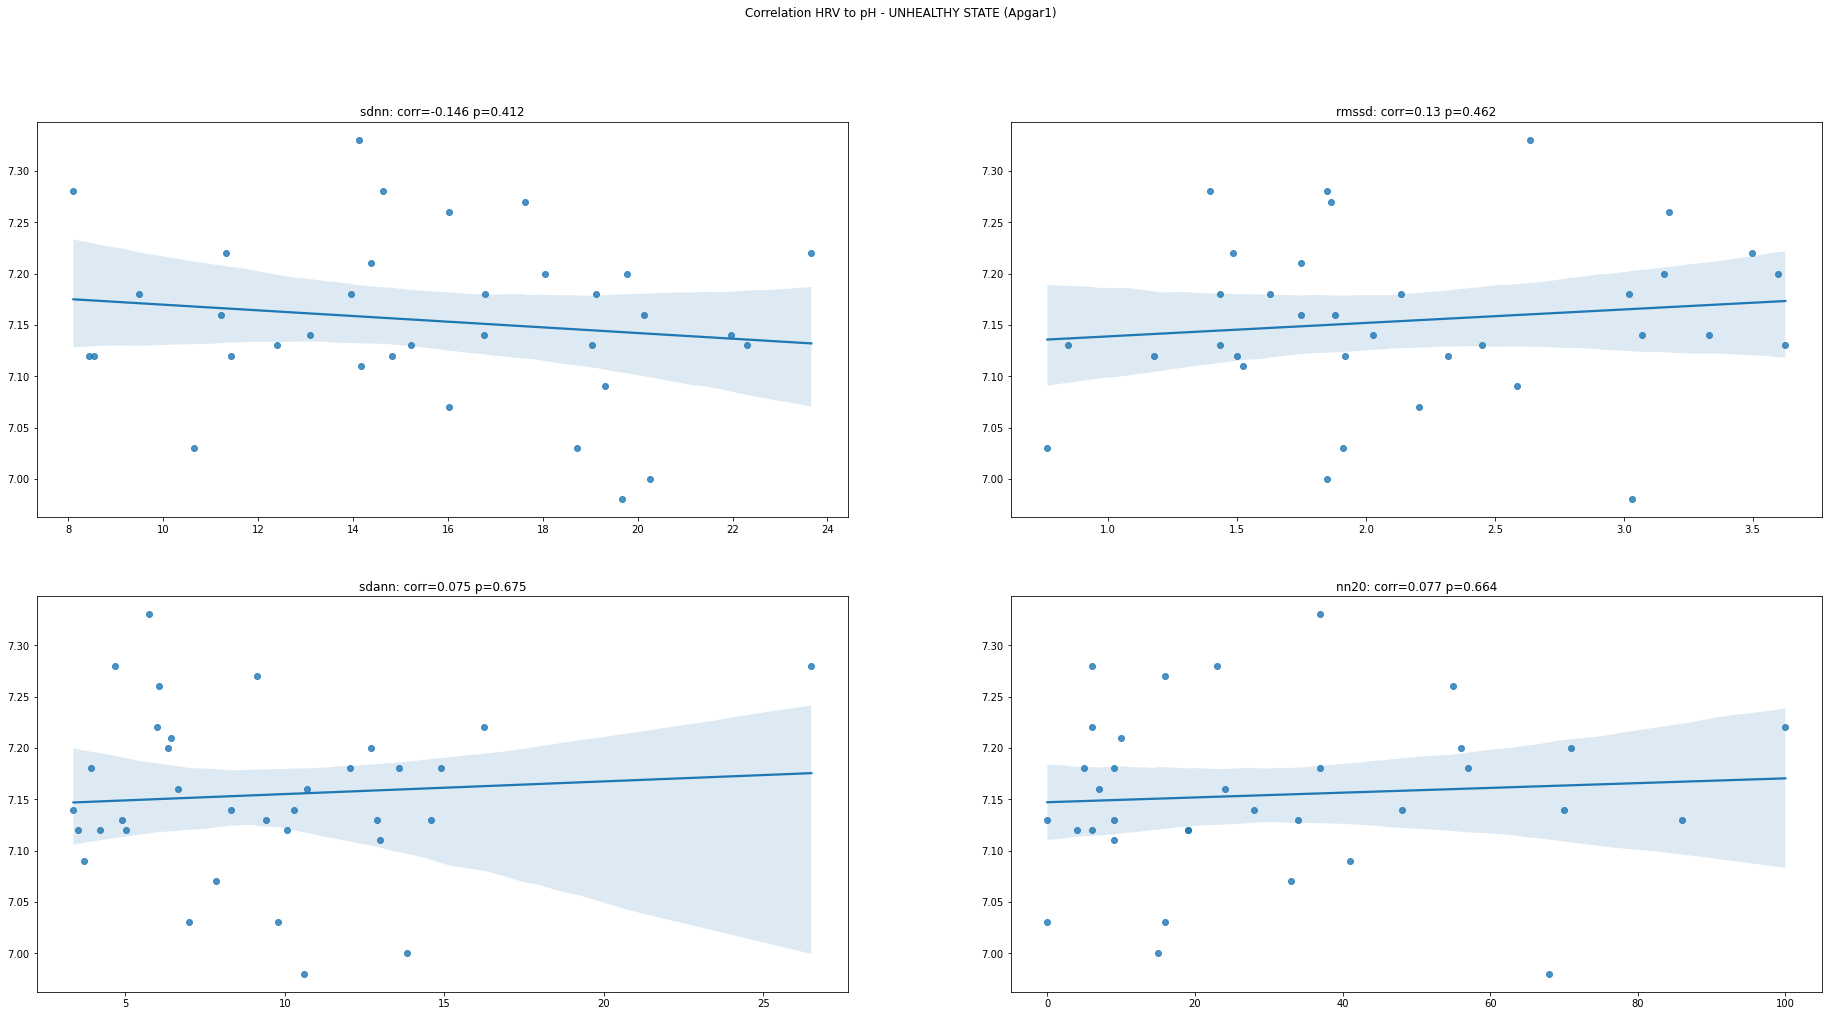

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(32, 16))

fig.suptitle('Correlation HRV to pH - UNHEALTHY STATE (Apgar1)')
axes[0][0].set_title('sdnn: corr=' + str(round(get_correlation(df1u_fin, clmn1='sdnn')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1u_fin, clmn1='sdnn')['pearsonr'][0][1],3))); 
axes[0][1].set_title('rmssd: corr=' + str(round(get_correlation(df1u_fin, clmn1='rmssd')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1u_fin, clmn1='rmssd')['pearsonr'][0][1],3))); 
axes[1][0].set_title('sdann: corr=' + str(round(get_correlation(df1u_fin, clmn1='sdann')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1u_fin, clmn1='sdann')['pearsonr'][0][1],3))); 
axes[1][1].set_title('nn20: corr=' + str(round(get_correlation(df1u_fin, clmn1='nn20')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df1u_fin, clmn1='nn20')['pearsonr'][0][1],3))); 

sns.regplot(ax=axes[0][0], x=[hrv_val for _, hrv_val in df1u_fin['sdnn'].iteritems()], y=[hrv_val for _, hrv_val in df1u_fin['pH'].iteritems()])
sns.regplot(ax=axes[0][1], x=[hrv_val for _, hrv_val in df1u_fin['rmssd'].iteritems()], y=[hrv_val for _, hrv_val in df1u_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][0], x=[hrv_val for _, hrv_val in df1u_fin['sdann'].iteritems()], y=[hrv_val for _, hrv_val in df1u_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][1], x=[hrv_val for _, hrv_val in df1u_fin['nn20'].iteritems()], y=[hrv_val for _, hrv_val in df1u_fin['pH'].iteritems()])

<AxesSubplot:title={'center':'nn20: corr=-0.193 p=0.002'}>

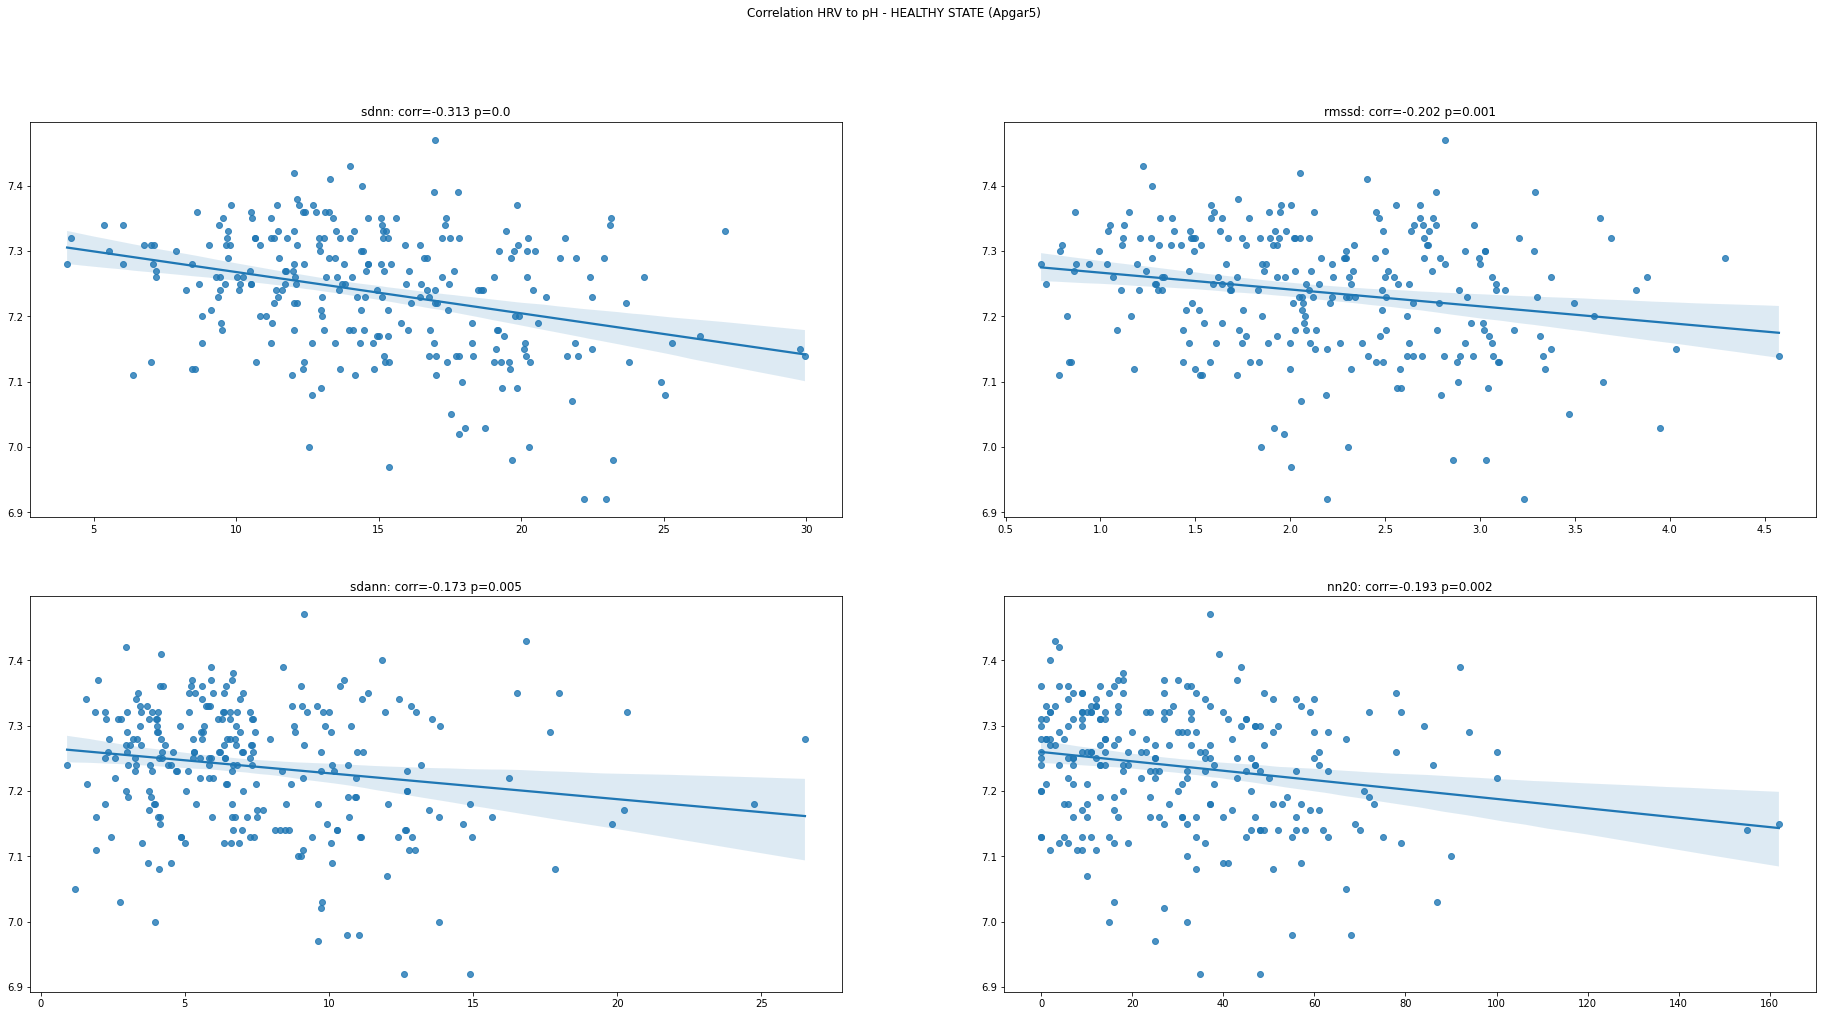

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(32, 16))

fig.suptitle('Correlation HRV to pH - HEALTHY STATE (Apgar5)')
axes[0][0].set_title('sdnn: corr=' + str(round(get_correlation(df5h_fin, clmn1='sdnn')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df5h_fin, clmn1='sdnn')['pearsonr'][0][1],3))); 
axes[0][1].set_title('rmssd: corr=' + str(round(get_correlation(df5h_fin, clmn1='rmssd')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df5h_fin, clmn1='rmssd')['pearsonr'][0][1],3))); 
axes[1][0].set_title('sdann: corr=' + str(round(get_correlation(df5h_fin, clmn1='sdann')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df5h_fin, clmn1='sdann')['pearsonr'][0][1],3))); 
axes[1][1].set_title('nn20: corr=' + str(round(get_correlation(df5h_fin, clmn1='nn20')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(df5h_fin, clmn1='nn20')['pearsonr'][0][1],3))); 

sns.regplot(ax=axes[0][0], x=[hrv_val for _, hrv_val in df5h_fin['sdnn'].iteritems()], y=[hrv_val for _, hrv_val in df5h_fin['pH'].iteritems()])
sns.regplot(ax=axes[0][1], x=[hrv_val for _, hrv_val in df5h_fin['rmssd'].iteritems()], y=[hrv_val for _, hrv_val in df5h_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][0], x=[hrv_val for _, hrv_val in df5h_fin['sdann'].iteritems()], y=[hrv_val for _, hrv_val in df5h_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][1], x=[hrv_val for _, hrv_val in df5h_fin['nn20'].iteritems()], y=[hrv_val for _, hrv_val in df5h_fin['pH'].iteritems()])

The results show that the correlation remains at the same levels (negative and statistically interest) only for the set of signals where the baby's health was measured good for both Apgar1 and Apgar5. One interpretation that may emerge is that baby's health can be more safely predicted as good when the measurements produce a point that is close to the area where the error is small (margin above and below fit line)

<BarContainer object of 234 artists>

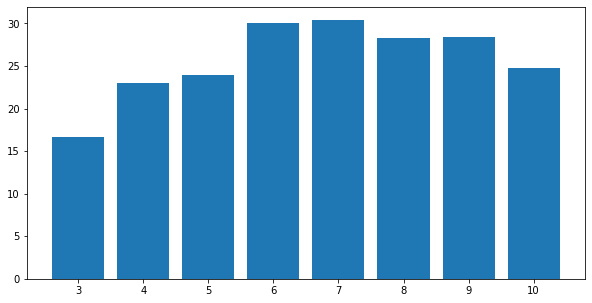

In [51]:
fig = plt.figure(figsize=(10,5))
plt.bar( 
    df_fin['Apgar1'],
    [ value for value in df_fin['sdnn'] ]
)

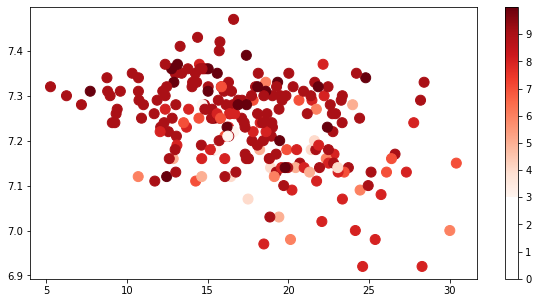

In [52]:
fig = plt.figure(figsize=(10,5))
plt.scatter(x=df_fin["sdnn"], y=df_fin["pH"], s=100, c=df_fin["Apgar1"], cmap='Reds')
cb = plt.colorbar()
cb.set_ticks(np.arange(0,10,1))

We can also conclude that good pH values are those in range [7.20 , 7.35]. We can distinguish a group - cluster of healthy cases that describes that range.

In [23]:
from scipy.stats import ttest_ind

t_stat, p = ttest_ind(df_fin.loc[df_fin.Apgar1 < 7, 'pH'], df_fin.loc[df_fin.Apgar1 >= 7, 'pH'] )
print(f't={t_stat}, p={p}')

t_stat, p = ttest_ind(df_fin.loc[df_fin.Apgar5 < 7, 'pH'], df_fin.loc[df_fin.Apgar5 >= 7, 'pH'] )
print(f't={t_stat}, p={p}')

t_stat, p = ttest_ind(df_fin.loc[df_fin.Apgar1 < 7, 'rmssd'], df_fin.loc[df_fin.Apgar1 >= 7, 'sdnn'] )
print(f't={t_stat}, p={p}')


t=-4.674986762521356, p=4.988150834672012e-06
t=-2.192455659757565, p=0.029340606211056303
t=-16.405743188719352, p=1.1288566199238743e-40


Analysis with no preprocessing

In [24]:
def dropres(df, name):
    records_to_drop = list()
    cc = ca = cd = cw = 0
    
    for i in range(df.shape[0]):
        if (df.iloc[i]['labels']['Deliv. type'] != 1.0):
            records_to_drop.append(i); cc+=1
    print(cc,' casarean records dropped')
    
    return df.drop(records_to_drop).reset_index().drop('index', axis=1)

In [25]:
testdf = drop_restictions(df,'df')
testdf_n = drop_noisy_records(testdf,thresh=0.2)
testdf_n_zs = drop_zero_segments(testdf_n, segment_size=10)
testdf_n_zs = testdf_n_zs.set_index('tag')
testdf_n_zs_sm = noise_retrieval(testdf_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)

-- df --
18  underweeked records dropped
86  diseased records dropped
0  underage records dropped
46  casarean records dropped
150 total records dropped


In [26]:
testdf_fin = compute_hrv(testdf_n_zs_sm)
testdf_fin.head()

  0%|          | 0/274 [00:00<?, ?it/s]

,Fhr,pH,Apgar1,Apgar5,Weight(g),labels,Healthy Birth (1),Healthy Birth (2),sdnn,rmssd,sdann,nn20
tag,,,,,,,,,,,,
1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",7.00,8.0,8.0,2900.0,Labels pH 7.00 BDecf ...,1.0,1.0,12.353824,2.329007,3.202710,32
1003,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",7.20,7.0,9.0,3770.0,Labels pH 7.20 BDecf ...,1.0,1.0,11.045326,1.158467,7.006527,0
1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",7.30,8.0,9.0,3370.0,Labels pH 7.30 BDecf ...,1.0,1.0,14.447848,1.493819,9.845639,9
1007,"[142.25, 142.25, 142.75, 142.75, 142.75, 142.7...",7.16,9.0,10.0,3220.0,Labels pH 7.16 BDecf ...,1.0,1.0,21.839136,2.591609,16.486361,28
1008,"[122.5, 122.5, 122.75, 122.75, 122.5, 122.5, 1...",7.36,8.0,9.0,3360.0,Labels pH 7.36 BDecf ...,1.0,1.0,12.300723,1.965254,5.293765,33


In [27]:
print('PearsonResult: ',get_correlation(testdf_fin, clmn1='sdnn')['pearsonr'])
print(get_correlation(testdf_fin, clmn1='sdnn')['spearmanr'])
print(get_correlation(testdf_fin, clmn1='sdnn')['kendalltau'])
print()
print('PearsonResult: ',get_correlation(testdf_fin, clmn1='rmssd')['pearsonr'])
print(get_correlation(testdf_fin, clmn1='rmssd')['spearmanr'])
print(get_correlation(testdf_fin, clmn1='rmssd')['kendalltau'])
print()
print('PearsonResult: ',get_correlation(testdf_fin, clmn1='sdann')['pearsonr'])
print(get_correlation(testdf_fin, clmn1='sdann')['spearmanr'])
print(get_correlation(testdf_fin, clmn1='sdann')['kendalltau'])
print()
print('PearsonResult: ',get_correlation(testdf_fin, clmn1='nn20')['pearsonr'])
print(get_correlation(testdf_fin, clmn1='nn20')['spearmanr'])
print(get_correlation(testdf_fin, clmn1='nn20')['kendalltau'])

PearsonResult:  [(-0.30416123226738584, 2.8380361019194736e-07)]
[SpearmanrResult(correlation=-0.2849421086652767, pvalue=1.6280868821751232e-06)]
[KendalltauResult(correlation=-0.19513834000568073, pvalue=2.1086426358093775e-06)]

PearsonResult:  [(-0.18588983271728204, 0.0020020183796772397)]
[SpearmanrResult(correlation=-0.19079834303118987, pvalue=0.0015085407603054814)]
[KendalltauResult(correlation=-0.12782865090015777, pvalue=0.0018912391664873322)]

PearsonResult:  [(-0.20907108768644767, 0.000494909903279932)]
[SpearmanrResult(correlation=-0.19087219043598447, pvalue=0.0015020525274308302)]
[KendalltauResult(correlation=-0.1303276385505646, pvalue=0.0015373612596336777)]

PearsonResult:  [(-0.18190523332595787, 0.002506472105691381)]
[SpearmanrResult(correlation=-0.1784235814788555, pvalue=0.0030391352418343088)]
[KendalltauResult(correlation=-0.12412406490949636, pvalue=0.002736052836634347)]


<AxesSubplot:title={'center':'nn20: corr=-0.182 p=0.003'}>

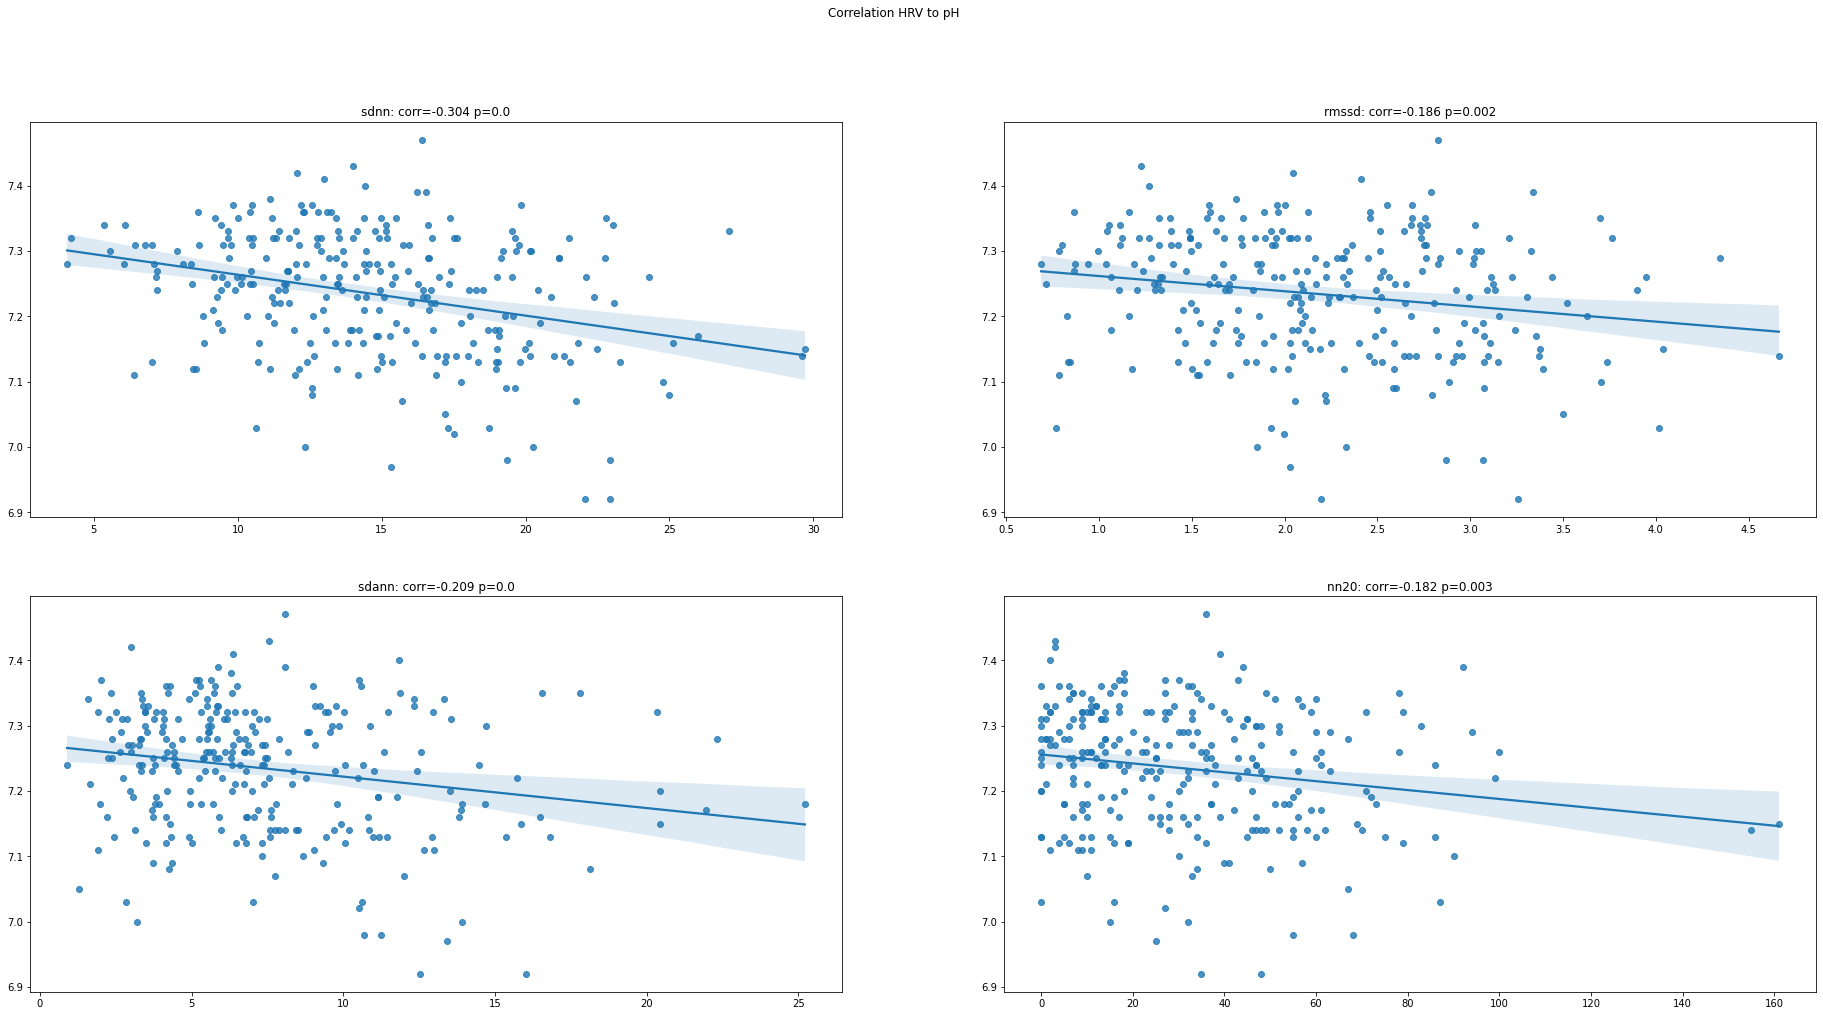

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(32, 16))
fig.suptitle('Correlation HRV to pH')
axes[0][0].set_title('sdnn: corr=' + str(round(get_correlation(testdf_fin, clmn1='sdnn')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='sdnn')['pearsonr'][0][1],3))); 
axes[0][1].set_title('rmssd: corr=' + str(round(get_correlation(testdf_fin, clmn1='rmssd')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='rmssd')['pearsonr'][0][1],3))); 
axes[1][0].set_title('sdann: corr=' + str(round(get_correlation(testdf_fin, clmn1='sdann')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='sdann')['pearsonr'][0][1],3))); 
axes[1][1].set_title('nn20: corr=' + str(round(get_correlation(testdf_fin, clmn1='nn20')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='nn20')['pearsonr'][0][1],3))); 

sns.regplot(ax=axes[0][0], x=[hrv_val for _, hrv_val in testdf_fin['sdnn'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['pH'].iteritems()])
sns.regplot(ax=axes[0][1], x=[hrv_val for _, hrv_val in testdf_fin['rmssd'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][0], x=[hrv_val for _, hrv_val in testdf_fin['sdann'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['pH'].iteritems()])
sns.regplot(ax=axes[1][1], x=[hrv_val for _, hrv_val in testdf_fin['nn20'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['pH'].iteritems()])

In [29]:
from scipy.stats import ttest_ind

t_stat, p = ttest_ind(testdf_fin.loc[testdf_fin.Apgar1 < 7, 'pH'], testdf_fin.loc[testdf_fin.Apgar1 >= 7, 'pH'] )
print(f't={t_stat}, p={p}')

t_stat, p = ttest_ind(testdf_fin.loc[testdf_fin.Apgar5 < 7, 'pH'], testdf_fin.loc[testdf_fin.Apgar5 >= 7, 'pH'] )
print(f't={t_stat}, p={p}')

t_stat, p = ttest_ind(testdf_fin.loc[testdf_fin.Apgar1 < 7, 'rmssd'], testdf_fin.loc[testdf_fin.Apgar1 >= 7, 'sdnn'] )
print(f't={t_stat}, p={p}')


t=-5.488476890157898, p=9.287567229868334e-08
t=-2.4969710107099776, p=0.013117609204145234
t=-15.292618031896863, p=1.5948703463723563e-38


Other correlations

In [30]:
print('PearsonResult: ',get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='sdnn')['pearsonr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='sdnn')['spearmanr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='sdnn')['kendalltau'])
print()
print('PearsonResult: ',get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='rmssd')['pearsonr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='rmssd')['spearmanr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='rmssd')['kendalltau'])
print()
print('PearsonResult: ',get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='sdann')['pearsonr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='sdann')['spearmanr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='sdann')['kendalltau'])
print()
print('PearsonResult: ',get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='nn20')['pearsonr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='nn20')['spearmanr'])
print(get_correlation(testdf_fin, clmn2='Weight(g)', clmn1='nn20')['kendalltau'])

PearsonResult:  [(-0.1421370608290154, 0.018572872151200688)]
[SpearmanrResult(correlation=-0.15425670657036034, pvalue=0.01055632700569041)]
[KendalltauResult(correlation=-0.10423655111847199, pvalue=0.01045287826894415)]

PearsonResult:  [(-0.1311017384733679, 0.030039330957517957)]
[SpearmanrResult(correlation=-0.1273861910184272, pvalue=0.035068177932104344)]
[KendalltauResult(correlation=-0.08275001648956769, pvalue=0.04208495425429276)]

PearsonResult:  [(0.008225030028725624, 0.8921941574014051)]
[SpearmanrResult(correlation=-0.035590094551236566, pvalue=0.5574633013368485)]
[KendalltauResult(correlation=-0.020868796758323302, pvalue=0.6082150165390182)]

PearsonResult:  [(-0.07045720511917396, 0.2450780626261629)]
[SpearmanrResult(correlation=-0.08050446673254882, pvalue=0.18396300602407112)]
[KendalltauResult(correlation=-0.054345958815508445, pvalue=0.18492401947683001)]


<AxesSubplot:title={'center':'nn20: corr=-0.182 p=0.003'}>

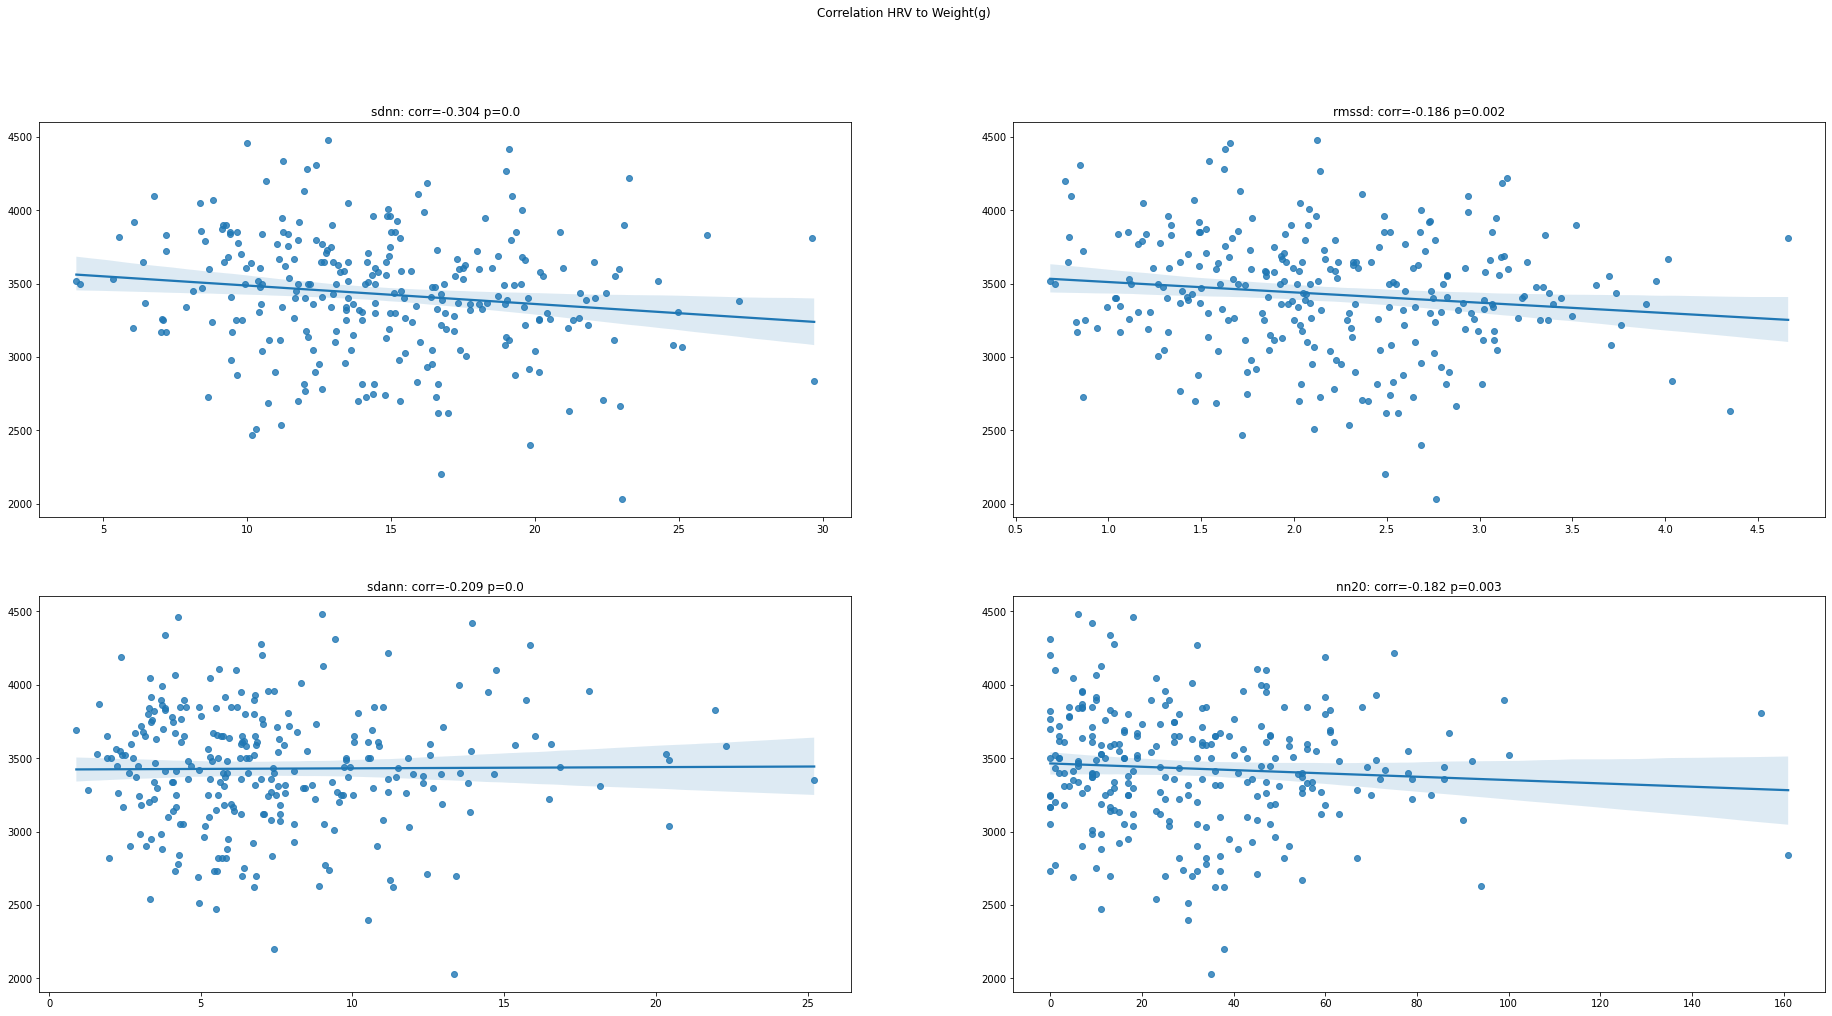

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(32, 16))
fig.suptitle('Correlation HRV to Weight(g)')
axes[0][0].set_title('sdnn: corr=' + str(round(get_correlation(testdf_fin, clmn1='sdnn')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='sdnn')['pearsonr'][0][1],3))); 
axes[0][1].set_title('rmssd: corr=' + str(round(get_correlation(testdf_fin, clmn1='rmssd')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='rmssd')['pearsonr'][0][1],3))); 
axes[1][0].set_title('sdann: corr=' + str(round(get_correlation(testdf_fin, clmn1='sdann')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='sdann')['pearsonr'][0][1],3))); 
axes[1][1].set_title('nn20: corr=' + str(round(get_correlation(testdf_fin, clmn1='nn20')['pearsonr'][0][0],3)) + ' p=' + str(round(get_correlation(testdf_fin, clmn1='nn20')['pearsonr'][0][1],3))); 

sns.regplot(ax=axes[0][0], x=[hrv_val for _, hrv_val in testdf_fin['sdnn'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['Weight(g)'].iteritems()])
sns.regplot(ax=axes[0][1], x=[hrv_val for _, hrv_val in testdf_fin['rmssd'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['Weight(g)'].iteritems()])
sns.regplot(ax=axes[1][0], x=[hrv_val for _, hrv_val in testdf_fin['sdann'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['Weight(g)'].iteritems()])
sns.regplot(ax=axes[1][1], x=[hrv_val for _, hrv_val in testdf_fin['nn20'].iteritems()], y=[hrv_val for _, hrv_val in testdf_fin['Weight(g)'].iteritems()])

In [32]:
from scipy.stats import ttest_ind

t_stat, p = ttest_ind(testdf_fin.loc[testdf_fin.Apgar1 < 7, 'Weight(g)'], testdf_fin.loc[testdf_fin.Apgar1 >= 7, 'Weight(g)'] )
print(f't={t_stat}, p={p}')

t_stat, p = ttest_ind(testdf_fin.loc[testdf_fin.Apgar5 < 7, 'Weight(g)'], testdf_fin.loc[testdf_fin.Apgar5 >= 7, 'Weight(g)'] )
print(f't={t_stat}, p={p}')

t_stat, p = ttest_ind(testdf_fin.loc[testdf_fin.Apgar1 < 7, 'rmssd'], testdf_fin.loc[testdf_fin.Apgar1 >= 7, 'sdnn'] )
print(f't={t_stat}, p={p}')


t=1.2361448035349112, p=0.21747115616452686
t=2.1232430137958582, p=0.03463643469183163
t=-15.292618031896863, p=1.5948703463723563e-38
